# House Prediction Program

Using California Housing Prices dataset (1990), to estimate the median house value of houses within a district

#### Method:
1. Load in the data
2. Create a training set
    - Method 1 : Randomly split the data into test and train sets
    - Method 2 : Use stratified sampling to split the data
3. Understand and visualize the data to gain insight
    - Look for correlation with the target feature
    - Look for correlation between attributes
    - Experiment with attribute combinations
4. Clean the data
    - Fill missing values
    - Handle text and categorical attributes
5. Create customer transformers
6. Create the transformation pipeline (used for data pre-processing)
    - Create a pipeline for numerical data and categorical / text if necessary
    - Combine numerical data pipeline with categorical / text to form final pipeline
7. Test different models using only test data
8. Fine-tune a chosen model(s)
    - Method 1 : Grid Search
    - Method 2 : Randomized Search
    - Method 3 : Ensemble Method
9. Analyse and change best models, their errors, and their best attributes
10. Evaluate final model on the test set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32

## Loading in the data

In [2]:
def load_housing_data(housing_path):
    return pd.read_csv(housing_path)

housing = load_housing_data("data/housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


x-axis : category\
y-axis : frequency

In [4]:
# housing.hist(bins=50, figsize=(20,15))
# plt.show()

## Creating a training set

#### Method 1 : Randomly splitting the data into test and train sets

In [ ]:
# identifier : what column to use to determine different splits
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# using index column to determine identify split rows
def split_train_test_by_id(data, test_ratio, index_col):
    ids = data[index_col]
    test_set = ids.apply(lambda id : test_set_check(id, test_ratio))
    return data.loc[~test_set], data.loc[test_set]

In [ ]:
housing_with_index = housing.reset_index() # makes sure index start from 0
train, test = split_train_test_by_id(housing_with_index, 0.2, "index")

#### Method 2 : Stratified sampling to split data
Reason: ensures the sample drawn from a population preserves the original distribution of important categories or groups (called strata)

In [4]:
# splitting data in median_income into strata depending on value and creating a new column in the df
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# uses newly created income_cat to perform stratified sampling 
split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [6]:
# removing the income_cat column as we do not need anymore
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discovering and visualising the data to gain insight

#### Visual of data's location

In [ ]:
# copy to play with
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

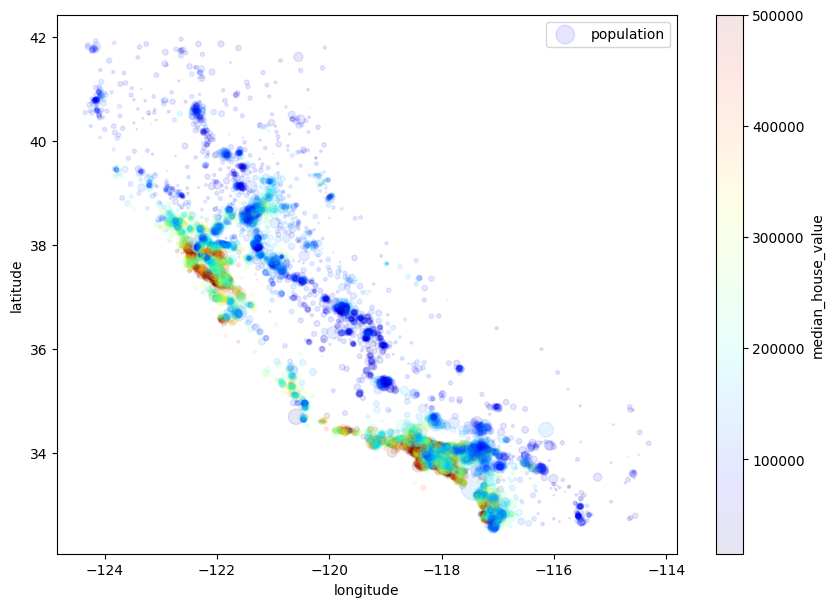

In [ ]:
housing.plot(
    kind="scatter", 
    x="longitude",
    y="latitude",
    alpha=0.1,
    s=housing["population"]/100,
    label="population",
    figsize=(10,7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True
)

#### Looking for correlation with target feature

In [ ]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

#### Looking for correlation between attributes

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

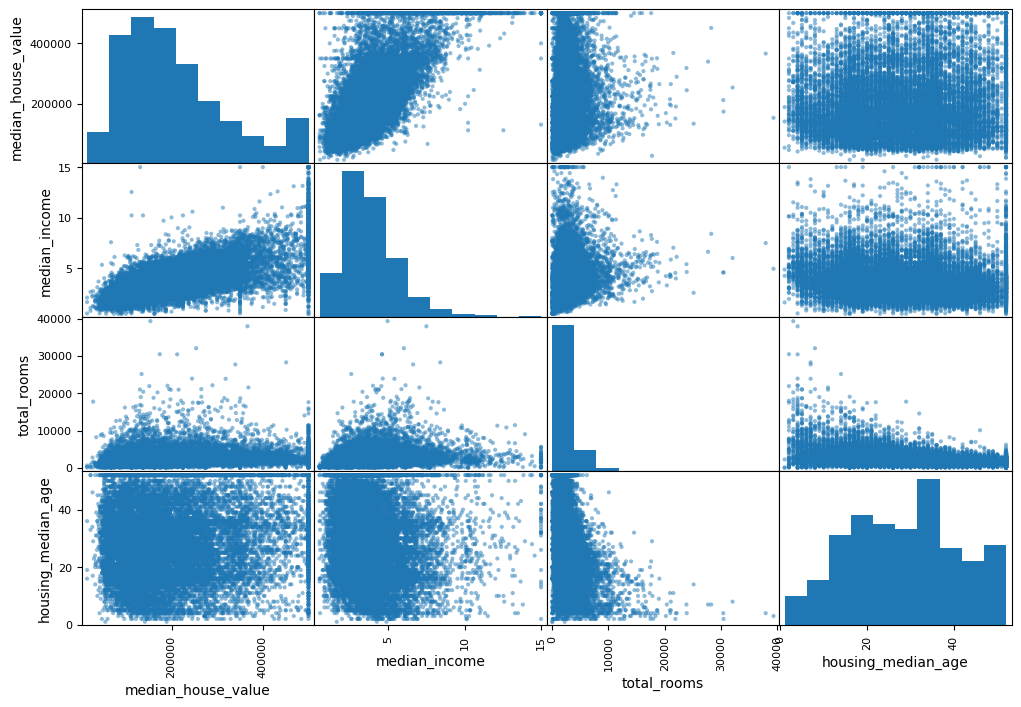

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

#### Experimenting with attribute combinations

In [7]:
# adding combination of attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household" ]=housing["population"]/housing["households" ]

In [8]:
# check correlation against target attribute
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## Preparing the data for Machine Learning Algorithms

In [9]:
housing = strat_train_set.drop("median_house_value", axis=1) # x-values (features)
housing_labels = strat_train_set["median_house_value"].copy() # y-values (labels)

## Data Cleaning

We have feature values missing in the total_bedrooms column. We have 3 options:
- Get rid of the corresponding districts
- Get rid of the whole attribute
- Set the values to some value (zero, the mean, the median, etc)

We will go with the third option

#### Handling Numerical Data
Filling in empty entries

In [ ]:
# option 1 : housing.dropna(subset=["total_bedrooms"])
# option 2 : housing.drop("total_bedrooms", axis=1)
# option 3 : median = housing["total_bedrooms"].median()
# option 3 : housing["total_bedrooms"].fillna(median, inplace=True)

In [ ]:
# sklearn version of option 3
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# since median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num) # finding median for all columns just to be safe

#imputer stores the median in the statistics_ instance variable (imputer.statistics_)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [ ]:
X = imputer.transform(housing_num) # fills the empty spaces with median, does not include column headings
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index) # converts numpy array (X) into dataframe

#### Handling Text and Categorical Attributes

In [ ]:
housing_cat = housing[["ocean_proximity"]]

In [ ]:
# encode the categorical values
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

housing_cat_encoded = cat_encoder.fit_transform(housing_cat) # outputs SciPy sparse matrix
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# adding bedrooms_per_room as a column
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix] 
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room] 
        else: 
            return np.c_[X, rooms_per_household, population_per_household]
        

class TopAttributeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs_ix=[]):
        self.attribs_ix = attribs_ix

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.delete(X, self.attribs_ix, axis=1)

## Transformation Pipeline

In [31]:
# pipeline for the numeric data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline ([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

Combining categorical and numerical data together

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# pass column headings only so that the transformer knows which columns to apply each transformer to
housing_num = housing.drop("ocean_proximity", axis=1)
nums_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = Pipeline([
    ("numCat", ColumnTransformer([
        ("num", num_pipeline, nums_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])),
    ("topAttribs", TopAttributeSelector(attribs_ix=[12, 13, 15]))
])

In [41]:
housing_prepared = full_pipeline.fit_transform(housing)

## Modelling

What we have done so far:
1. Explored data
2. Split training and testing data
3. Wrote transformation pipelines to clean up and prepare the data

#### Model 1 : Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# evaulation
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

#cross validation
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_rmse_score = np.sqrt(-scores) # -scores cause cross_val_score thinks higher scores = better performance
lin_rmse_score.mean()

np.float64(69476.75503274854)

#### Model 2 : Decision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
# tree_reg.fit(housing_prepared, housing_labels)

# cross validation
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores.mean()

np.float64(71025.19438426447)

#### Model : Random Forest Regressor

training score : how well the model performs on the training data
validation score : how well the model performs on unseen (validation) data during cross-validation

We can see we are still overfitting with the model as the training score is significantly lower than the validation score. Our solutions are to:
1. Simplify the model
2. Constrain the model (i.e. regularize it)
3. Get a lot more training data

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(forest_predictions, housing_labels)
forest_rmse = np.sqrt(forest_mse)
forest_rmse # training score

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
forest_rmse_scores.mean() # verification score

KeyboardInterrupt: 

## Fine-tuning a chosen model

#### Method 1 : Grid Search

param_grid arguments:
Dictionary 1: represents all combinations where bootstrap is True
- n_estimators: the number of trees in the forest
- max_features: the number of features to consider when looking for the best split

bootstrap
- Bootstrapping is a sampling technique where you randomly select data with replacement from your dataset to create a new sample
- So some data points may appear multiple times, while others may not appear at all in the sample

In [ ]:
from sklearn.model_selection import GridSearchCV

# stating the parameters to change and values to try
param_grid = [
    {"n_estimators": [3, 10, 30, 50, 100], "max_features": [2, 4, 6, 8, 10]},
    {"bootstrap": [False], "n_estimators": [3,10, 30, 50, 100], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
# putting it all together
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv = 5,
    scoring="neg_mean_squared_error",
    return_train_score=True
)

# specifying the x and y data to use
grid_search.fit(housing_prepared, housing_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10, ...]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [ ]:
# showing the results for each parameter combination
cvres = grid_search.cv_results_ 
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63287.93421968361 {'max_features': 2, 'n_estimators': 3}
55437.4162727447 {'max_features': 2, 'n_estimators': 10}
52407.021235173546 {'max_features': 2, 'n_estimators': 30}
51954.40963531844 {'max_features': 2, 'n_estimators': 50}
51576.13506807379 {'max_features': 2, 'n_estimators': 100}
60742.59669081121 {'max_features': 4, 'n_estimators': 3}
52871.00518380369 {'max_features': 4, 'n_estimators': 10}
50384.074832236154 {'max_features': 4, 'n_estimators': 30}
49835.04912152774 {'max_features': 4, 'n_estimators': 50}
49474.81288453042 {'max_features': 4, 'n_estimators': 100}
58428.61759084661 {'max_features': 6, 'n_estimators': 3}
52355.64514967249 {'max_features': 6, 'n_estimators': 10}
50052.359293917056 {'max_features': 6, 'n_estimators': 30}
49331.991988202004 {'max_features': 6, 'n_estimators': 50}
49222.535561107885 {'max_features': 6, 'n_estimators': 100}
58828.834383402 {'max_features': 8, 'n_estimators': 3}
52031.483213204956 {'max_features': 8, 'n_estimators': 10}
50195.338940

In [ ]:
# finding the best parameters
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 100}

#### Method 2 : Randomized Search

Grid search fine when exploring relatively few combinations like in our use case, but whne the search space of hyperparameters is large, use RandomizedSearchCV.

Can be used in much the same way as the GridSeachCV but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hypterparameter at every iteration

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor()

param_grid = {
    "n_estimators": [3, 10, 30, 50, 100],
    "max_features": [2, 3, 4, 6, 8, 10],
    "bootstrap": [True, False]
}

rand_search = RandomizedSearchCV (
    forest_reg,
    param_distributions=param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42
)

rand_search.fit(housing_prepared, housing_labels)

rand_search.best_estimator_

ValueError: Found input variables with inconsistent numbers of samples: [20640, 16512]

In [16]:
rand_search.best_params_

{'n_estimators': 100, 'max_features': 4, 'bootstrap': False}

In [17]:
rmse = np.sqrt(-rand_search.best_score_)
rmse

np.float64(48686.65000560594)

#### Method 3 : Ensemble Method

Where you try to combine the models that perform the best

## Analyse the best models and their errors and best attributes

In [18]:
# finding the best attributes for RandomForestRegressor model
feature_importance = rand_search.best_estimator_.feature_importances_
feature_importance

array([8.87924926e-02, 8.05170897e-02, 4.30392408e-02, 2.06137750e-02,
       1.88746356e-02, 2.07631305e-02, 1.92809103e-02, 2.91266209e-01,
       6.80336557e-02, 1.00093518e-01, 8.52664894e-02, 1.89875120e-02,
       1.30149457e-01, 6.67686009e-05, 6.57388171e-03, 7.68123415e-03])

In [19]:
# displaying attribute importance with attribute name
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"] 
cat_encoder = full_pipeline.named_transformers_["cat"] 
cat_one_hot_attribs = list(cat_encoder.categories_[0]) 
attributes = nums_attribs + extra_attribs + cat_one_hot_attribs 
sorted(zip(feature_importance, attributes), reverse=True)

[(np.float64(0.29126620925132934), 'median_income'),
 (np.float64(0.13014945658356436), 'INLAND'),
 (np.float64(0.10009351823526054), 'population_per_household'),
 (np.float64(0.08879249261378518), 'longitude'),
 (np.float64(0.08526648940772923), 'bedrooms_per_room'),
 (np.float64(0.08051708966269101), 'latitude'),
 (np.float64(0.06803365572392503), 'rooms_per_household'),
 (np.float64(0.04303924076297266), 'housing_median_age'),
 (np.float64(0.02076313051842742), 'population'),
 (np.float64(0.020613774996579765), 'total_rooms'),
 (np.float64(0.019280910271926015), 'households'),
 (np.float64(0.01898751196431419), '<1H OCEAN'),
 (np.float64(0.01887463555315497), 'total_bedrooms'),
 (np.float64(0.007681234145683632), 'NEAR OCEAN'),
 (np.float64(0.006573881707723718), 'NEAR BAY'),
 (np.float64(6.676860093301949e-05), 'ISLAND')]

## Evaluation on Test Set

In [20]:
# selecting the best model discovered by fine tuning
final_model = rand_search.best_estimator_

# specifying X and y values
X_test = strat_test_set.drop("median_house_value", axis=1) 
y_test = strat_test_set["median_house_value"].copy()

# preprocessing the X values
X_test_prepared = full_pipeline.fit_transform(X_test) 
# making predictions with the preprocessed values
final_predictions = final_model.predict(X_test_prepared)

# calculating final rmse score
final_mse = mean_squared_error(y_test, final_predictions) 
final_rmse = np.sqrt(final_mse)

In [21]:
# final rmse score
final_rmse

np.float64(60873.40516618856)

#### Confidence Interval

Your result may be better than the current model in production, but is it by luck or is it actually better? Confidence interval can help answer this

We will find the range which we are 95% sure the true test RMSE lies in

In [22]:
from scipy import stats
confidence = 0.95

# part of formula for calculating confidence interval
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(
    confidence,
    len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)
))

array([59083.48945945, 62612.17282884])

#### Visual plot of predicted results against actual values

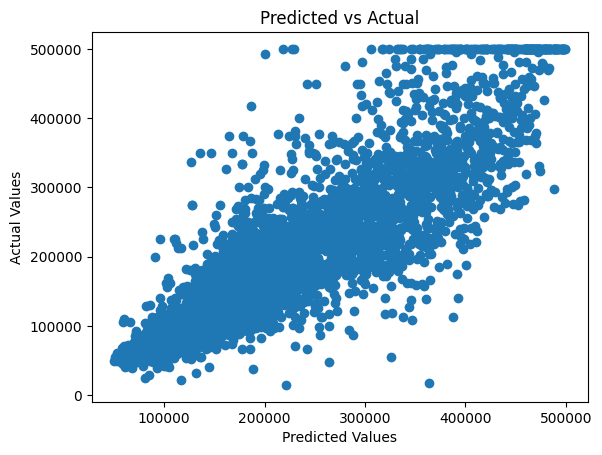

In [34]:
plt.scatter(final_predictions, y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual")
plt.show()